In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA

In [2]:
sessionPath = '/Users/erinkunz/Desktop/InnerSpeech/'

participantNames = ['T12','T15','T16','T17']
arrayNames = [['ventral6v'],['ventral6v','55b'],['ventral6v'],['dorsal6v-v','dorsal6v-d']] #,'dorsal6v_combined']]
chanSets = [[np.concatenate((np.arange(0,64),np.arange(128,192)))],[np.concatenate((np.arange(0,64),np.arange(256,320))),np.concatenate((np.arange(128,192),np.arange(384,448)))],[np.concatenate((np.arange(64,128),np.arange(320,384)))],[np.concatenate((np.arange(0,64),np.arange(256,320))),np.concatenate((np.arange(64,128),np.arange(320,384)))]] #,np.concatenate((np.arange(0,128),np.arange(256,384)))]]
sessions = ['t12.2023.08.15','t15.2024.04.07','t16.2024.03.04','t17.2024.12.09']

windowS = scipy.io.loadmat('/Users/erinkunz/Desktop/InnerSpeech/Derived/OptimalWindowDecoding/optimalWindowsAll.mat')
windows = windowS['bestWindows']

behaviorConditions = [[2,3,4,5,6,7,8],[10,11,12,13,14,15,16],[18,19,20,21,22,23,24],[26,27,28,29,30,31,32],[34,35,36,37,38,39,40],[42,43,44,45,46,47,48],[50,51,52,52,54,55,56]] # matlab indexing
behaviorNames = ['Attempted','Mimed','Motoric Inner Speech','Auditory Inner Speech','Imagined Listening','Listening','Silent Reading']

In [3]:
# some helper functions
def getXStackAve(byCue, cues):
    for cue in cues:
        Xs = byCue[cue]
        #print(Xs.shape)
        Xs = np.reshape(Xs,(Xs.shape[0],Xs.shape[1]*Xs.shape[2]))
        #print(Xs.shape)
        if cue == cues[0]:
            stack = np.mean(Xs,axis=0)
            stack = np.expand_dims(stack, axis=0)
            cuestack = [cue] 
        else:
            stackIt = np.mean(Xs,axis=0)
            stackIt = np.expand_dims(stackIt, axis=0)
            stack = np.concatenate((stack,stackIt),axis=0)
            cuestack.append(cue)
        #print(stack.shape)
        #stack = stack - np.mean(stack,axis)
    meanStack = np.mean(stack,axis=0)
    stack = stack - meanStack
    return stack, cuestack
def unscramble3d(plotPoints):
    midpt = [np.mean(plotPoints[0,:]), np.mean(plotPoints[1,:]),np.mean(plotPoints[2,:])]
    orientations = [[0,1],[1,2],[0,2]]
    orders = []
    for orientation in orientations:
        print(orientation)
        angles = []
        for x in plotPoints:
            #angle = np.arctan2(x[0] - midpt[0],x[1] - midpt[1])
            angle = np.arctan2(x[orientation[0]],x[orientation[1]])
            angles.append(angle)
        
        order = list(np.argsort(angles))
        order.append(order[0])
        orders.append(order)
    return orders

In [7]:
behavior2fit = 0 # pick which behavior to fit PCA space to

plotPointsByPandA = {}
expVarByPandA = {}
for pIdx,participant in enumerate(participantNames):
    # load and smooth data
    session = sessions[pIdx]
    dat = scipy.io.loadmat(sessionPath + 'Data/isolatedVerbalBehaviors/' + session + '_allBehaviors_raw.mat')
    arrays = arrayNames[pIdx]
    if pIdx > 0:
        smoothBins = 10
    else:
        smoothBins = 5
    features = np.concatenate((dat['binnedTX'],dat['spikePow']),1)
    # block mean subtraction
    blockNums = np.unique(dat['blockNum'])
    for b in blockNums:
        loopIdx = np.squeeze(dat['blockNum'] == b)
        features[loopIdx,:] -= np.mean(features[loopIdx,:],axis=0)
        
    smoothFeat = gaussian_filter1d(features, sigma=smoothBins,axis=0)
    smoothFeat = scipy.stats.zscore(smoothFeat)
    smoothFeat[np.isnan(smoothFeat)] = 1.0
    for arrayIdx in range(len(arrays)):
        chans = chanSets[pIdx][arrayIdx]
        smoothFeatChan = smoothFeat[:,chans]
        
        # analysisWindow by behavior by channel
        
        byCue = {}
        for i in range(len(dat['cueList'][0])):
            if i % 8 == 0: 
                continue
            behaviorIdx = int(np.floor(i/8))
            analysisWindow = windows[0][pIdx][0][behaviorIdx][0][arrayIdx][0]
            trlIdx = np.where(dat['trialCues'] == i+1)[0] # again matlab indexing
            startTimes = np.array(dat['goTrialEpochs'][trlIdx,0] + analysisWindow[0]).astype(int)
            endTimes = np.array(dat['goTrialEpochs'][trlIdx,0] + analysisWindow[1]).astype(int)
            thisXs = np.zeros((len(endTimes),analysisWindow[1]- analysisWindow[0],len(chanSets[pIdx][arrayIdx])))
            for j in range(len(endTimes)):
                thisXs[j,:,:] = smoothFeatChan[startTimes[j]:endTimes[j],:]
            byCue[i+1] = thisXs # matlab indexing
            
        
        X,y = getXStackAve(byCue,behaviorConditions[behavior2fit])
        pca = PCA()
        pca.fit(X)
        Up = pca.components_

        plotPoints = np.zeros((7,7,3)) # behavior x word x 2 pcs
        for b, behavior in enumerate(behaviorConditions):
            X2,y2 = getXStackAve(byCue,behavior)
            for i in range(X2.shape[0]):
                trial = X2[i]
                word = y2[i] % 8
                proj = Up[0:3,:] @ trial
                plotPoints[b,i,:] = proj
        plotPointsByPandA[(pIdx,arrayIdx)] = plotPoints
        expVarByPandA[(pIdx,arrayIdx)] = pca.explained_variance_ratio_

<IPython.core.display.Javascript object>


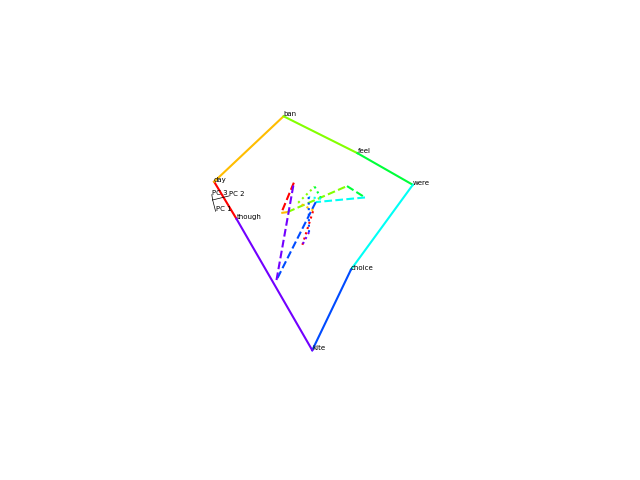

[0, 1]
[1, 2]
[0, 2]


In [8]:
#3d plot
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
words = ['ban','choice','day','feel','kite','though','were']

style = ['solid','dashed','dotted','dotted','dotted','dotted','dotted']


pIdx = 3
arrayIdx = 0
# 0 - Attempted, 1 - Mimed, 2 - Imagined Motoric, 3 - Imagined Auditory, 4 - Imagined Listening, 5 - Listening, 6 - Reading
bIdx1 = 0
bIdx2 = 1
bIdx3 = 4


arrays = arrayNames[arrayIdx]
pp = plotPointsByPandA[(pIdx,arrayIdx)]
orders = unscramble3d(pp[behavior2fit,:,:])

#orders used [[0],[2,0],[2],[0,]]

order = orders[0]
behaviorOrder = [behavior2fit,bIdx2,bIdx3]

for i in behaviorOrder:
    for l in range(len(order) - 1):
        ax.plot(xs=pp[i,order[l:l+2],0], ys=pp[i,order[l:l+2],1],zs=pp[i,order[l:l+2],2], zdir='z', linestyle=style[i], c=plt.cm.hsv(l/len(order)))
        #ax.plot(pp[i,order[l],0], pp[i,order[l],1],pp[i,order[l],2],'.',color=plt.cm.hsv(l/len(order)))
            
for j in range(7):
    textx = pp[bIdx1,j,0]
    texty = pp[bIdx1,j,1]
    textz = pp[bIdx1,j,2]
    ax.text(textx,texty,textz,words[j],fontsize=5)
    
    
    
sizeAx=4
transX = -20
transY = -20
transZ = -20
ax.plot([transX, transX],[transY, transY],[transZ, transZ+ sizeAx],'k',linewidth=0.5)
ax.text(transX,transY,transZ + sizeAx,'PC 3',fontsize=5)
ax.plot([transX, transX],[transY, transY+sizeAx],[transZ, transZ],'k',linewidth=0.5)
ax.text(transX,transY+sizeAx,transZ,'PC 2',fontsize=5)
ax.plot([transX, transX+sizeAx],[transY, transY],[transZ, transZ],'k',linewidth=0.5)
ax.text(transX+sizeAx,transY,transZ,'PC 1',fontsize=5)
ax.axis('off')
plt.show()